In [1]:
import math
import numpy as np
import scipy.io
from simple import nmf_son
import matplotlib.pyplot as plt

np.random.seed(42)
np.set_printoptions(precision=3)

In [2]:
def load_results(filepath):
    data = np.load(filepath)
    return data['Wb'], data['Hb'], data['Wl'], data['Hl'], data['fscores'], data['gscores'], data['lambda_vals']

In [3]:
mat = scipy.io.loadmat('urban/Urban.mat')
X = mat['X']

m, n = X.shape # (162, 94249)
num_col = int(math.sqrt(n)) # 307

X3d = X.reshape(m, num_col, num_col, order='F')

### Small

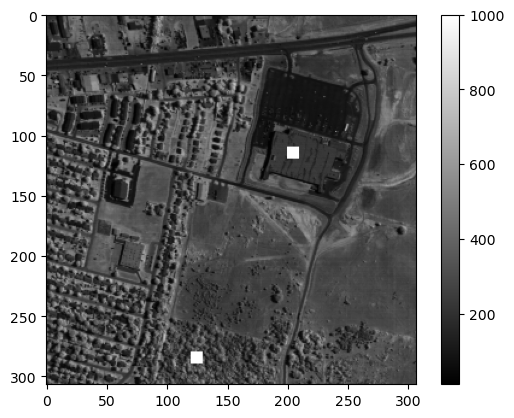

In [4]:
wavelength = 80

img = X3d[wavelength, :, :].copy()
img[280: 290, 120: 130] = 1000 # trees
img[110: 120, 200: 210] = 1000 # roof
plt.imshow(img, cmap='gray')
plt.colorbar()

In [5]:
save_filepath = 'urban/2022_11_17/small/r{}-l{}-it{}.npz'
X = np.load('urban/2022_11_17/small/X.npz')['X']

rank = 6
reg = 2
iters = 5000

Wb, Hb, Wl, Hl, fscores, gscores, lambda_vals = load_results(save_filepath.format(rank, reg, iters))

In [6]:
# Wb, Hb, Wl, Hl, new_fscores, new_gscores, new_lambda_vals = nmf_son(X, Wl, Hl, _lambda=reg, itermax=45000, scale_lambda=True)
# fscores = np.append(fscores[:-1], new_fscores)
# gscores = np.append(gscores[:-1], new_gscores)
# lambda_vals = np.append(lambda_vals[:-1], new_lambda_vals)
#
# with open(save_filepath.format(rank, reg, 50000), 'wb') as fout:
#     np.savez_compressed(fout, Wb=Wb, Hb=Hb, Wl=Wl, Hl=Hl, fscores=fscores, gscores=gscores, lambda_vals=lambda_vals)

### Custom

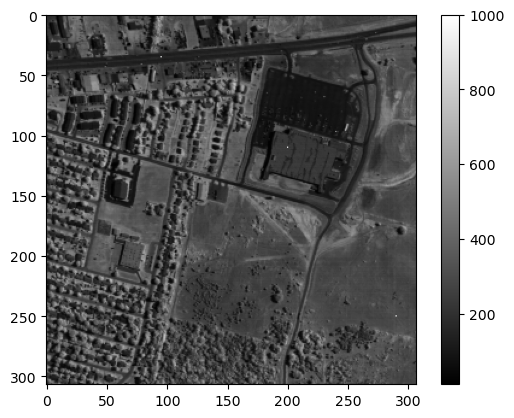

In [7]:
img = X3d[wavelength, :, :].copy()
img[35: 36, 95: 96] = 1000 # asphalt
img[250: 251, 290: 291] = 1000 # grass
img[110: 111, 200: 201] = 1000 # roof
plt.imshow(img, cmap='gray')
plt.colorbar()

In [8]:
save_filepath = 'urban/2022_11_17/custom/r{}-l{}-it{}.npz'
X = np.load('urban/2022_11_17/custom/X_gt.npz')['X']

rank = 6
reg = 2
iters = 5000

Wb, Hb, Wl, Hl, fscores, gscores, lambda_vals = load_results(save_filepath.format(rank, reg, iters))

In [9]:
# Wb, Hb, Wl, Hl, new_fscores, new_gscores, new_lambda_vals = nmf_son(X, Wl, Hl, _lambda=reg, itermax=45000, scale_lambda=True)
# fscores = np.append(fscores[:-1], new_fscores)
# gscores = np.append(gscores[:-1], new_gscores)
# lambda_vals = np.append(lambda_vals[:-1], new_lambda_vals)
#
# with open(save_filepath.format(rank, reg, 50000), 'wb') as fout:
#     np.savez_compressed(fout, Wb=Wb, Hb=Hb, Wl=Wl, Hl=Hl, fscores=fscores, gscores=gscores, lambda_vals=lambda_vals)

### Full

In [10]:
mat = scipy.io.loadmat('urban/Urban.mat')
X = mat['X']

In [11]:
save_filepath = 'urban/2022_11_19/full/r{}-l{}-it{}.npz'

rank = 10
reg = 10

# Wb, Hb, Wl, Hl, fscores, gscores, lambda_vals = load_results(save_filepath.format(rank, reg, iters))
data = np.load('urban/2022_11_19/full/r10_ini.npz')
iniW = data['W']
iniH = data['H']

In [12]:
# it_ckpts = [100, 200, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
#
# Wb, Hb, Wl, Hl, fscores, gscores, lambda_vals = nmf_son(X, iniW.copy(), iniH.copy(), _lambda=reg, itermax=it_ckpts[0], scale_lambda=True)
# with open(save_filepath.format(rank, reg, it_ckpts[0]), 'wb') as fout:
#     np.savez_compressed(fout, Wb=Wb, Hb=Hb, Wl=Wl, Hl=Hl, fscores=fscores, gscores=gscores, lambda_vals=lambda_vals)
#
# for k in range(1, len(it_ckpts)):
#     Wb, Hb, Wl, Hl, new_fscores, new_gscores, new_lambda_vals = nmf_son(X, Wl, Hl, _lambda=reg, itermax=it_ckpts[k] - it_ckpts[k-1], scale_lambda=True)
#
#     fscores = np.append(fscores[:-1], new_fscores)
#     gscores = np.append(gscores[:-1], new_gscores)
#     lambda_vals = np.append(lambda_vals[:-1], new_lambda_vals)
#
#     with open(save_filepath.format(rank, reg, it_ckpts[k]), 'wb') as fout:
#         np.savez_compressed(fout, Wb=Wb, Hb=Hb, Wl=Wl, Hl=Hl, fscores=fscores, gscores=gscores, lambda_vals=lambda_vals)
#     print(rank, reg, it_ckpts[k], 'complete')

### Smaller

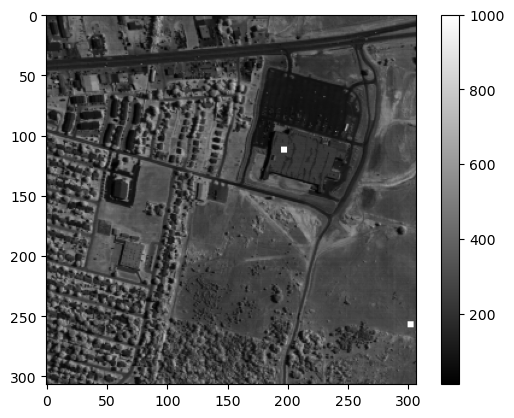

In [13]:
img = X3d[wavelength, :, :].copy()
img[255: 260, 300: 305] = 1000 # trees
img[110: 115, 195: 200] = 1000 # roof
plt.imshow(img, cmap='gray')
plt.colorbar()